In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [11]:
# Input variables as integers
year = 2019
month = 2
start_day = 25
start_hour = 0
end_day = 25
end_hour = 23

# Format the integers into the desired string format
year_month = f'{year}{month:02d}'  # yyyymm
start_time = f'{year}{month:02d}{start_day:02d}{start_hour:02d}'  # yyyymmddhh (start)
end_time = f'{year}{month:02d}{end_day:02d}{end_hour:02d}'  # yyyymmddhh (end)

# Define the URLs for the datasets of the variables we want to download (temperature, geopotential height, humidity, v-wind, u-wind)
urls = {
    'temperature_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_130_t.ll025sc.{start_time}_{end_time}.nc',
    'geopotential_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_129_z.ll025sc.{start_time}_{end_time}.nc',
    'mslp_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc',
    'humidity_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_133_q.ll025sc.{start_time}_{end_time}.nc',
    'v_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_132_v.ll025uv.{start_time}_{end_time}.nc',
    'u_wind_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_131_u.ll025uv.{start_time}_{end_time}.nc',
    'u_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc',
    'v_wind_sfc': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/{year_month}/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc',
    'pv_pl': f'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/{year_month}/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/{year_month}/e5.oper.an.pl.128_060_pv.ll025sc.{start_time}_{end_time}.nc'  # PV URL
}

# Load the datasets from the URLs
datasets = {}
for var, url in urls.items():
    tds_catalog = TDSCatalog(url)
    ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
    ds = xr.open_dataset(ds_url).metpy.parse_cf()
    datasets[var] = ds

# Merge all pressure level datasets into a single Xarray Dataset
ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], datasets['v_wind_pl'], datasets['u_wind_pl'], datasets['pv_pl']])

# Merge all surface datasets into a single Xarray Dataset
ds_sfc = xr.merge([datasets['mslp_sfc'], datasets['v_wind_sfc'], datasets['u_wind_sfc']])

C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022500_2019022523.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,
C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022500_2019022523.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g

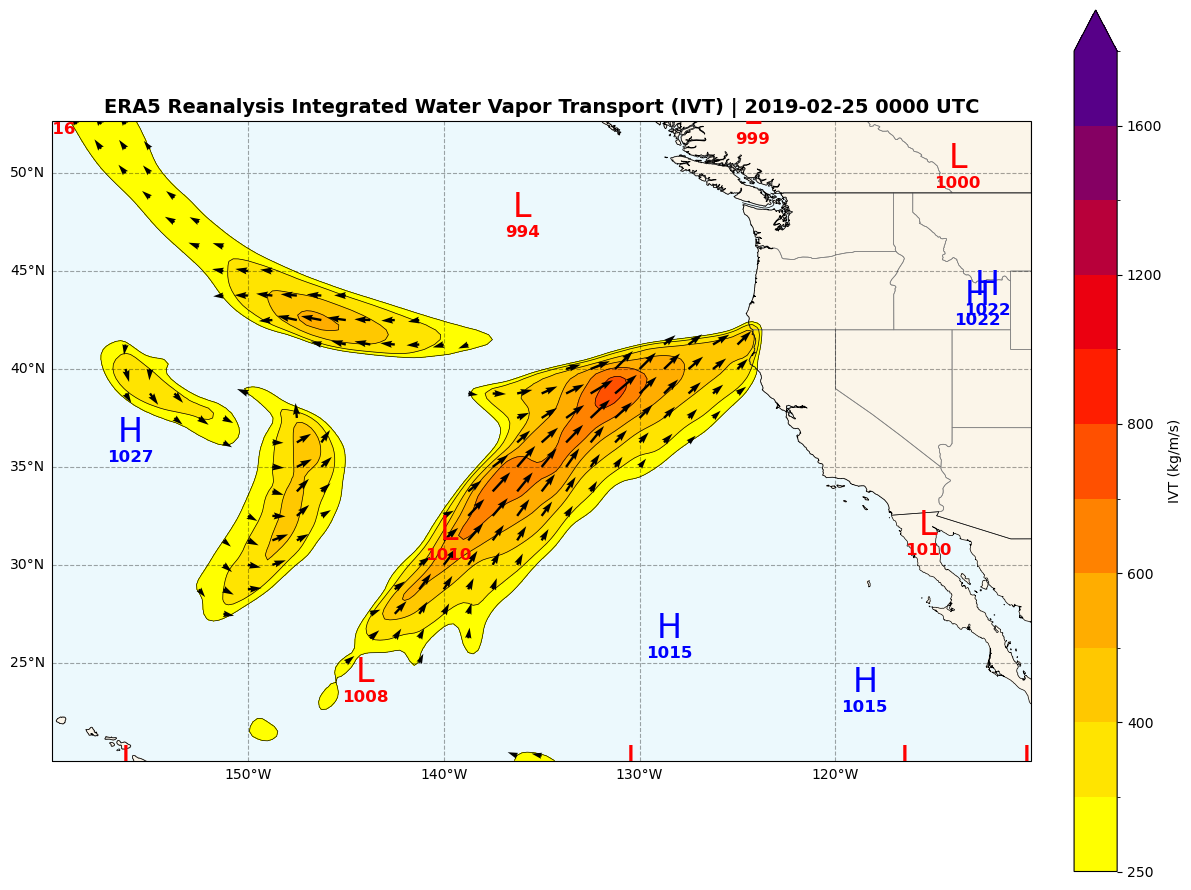

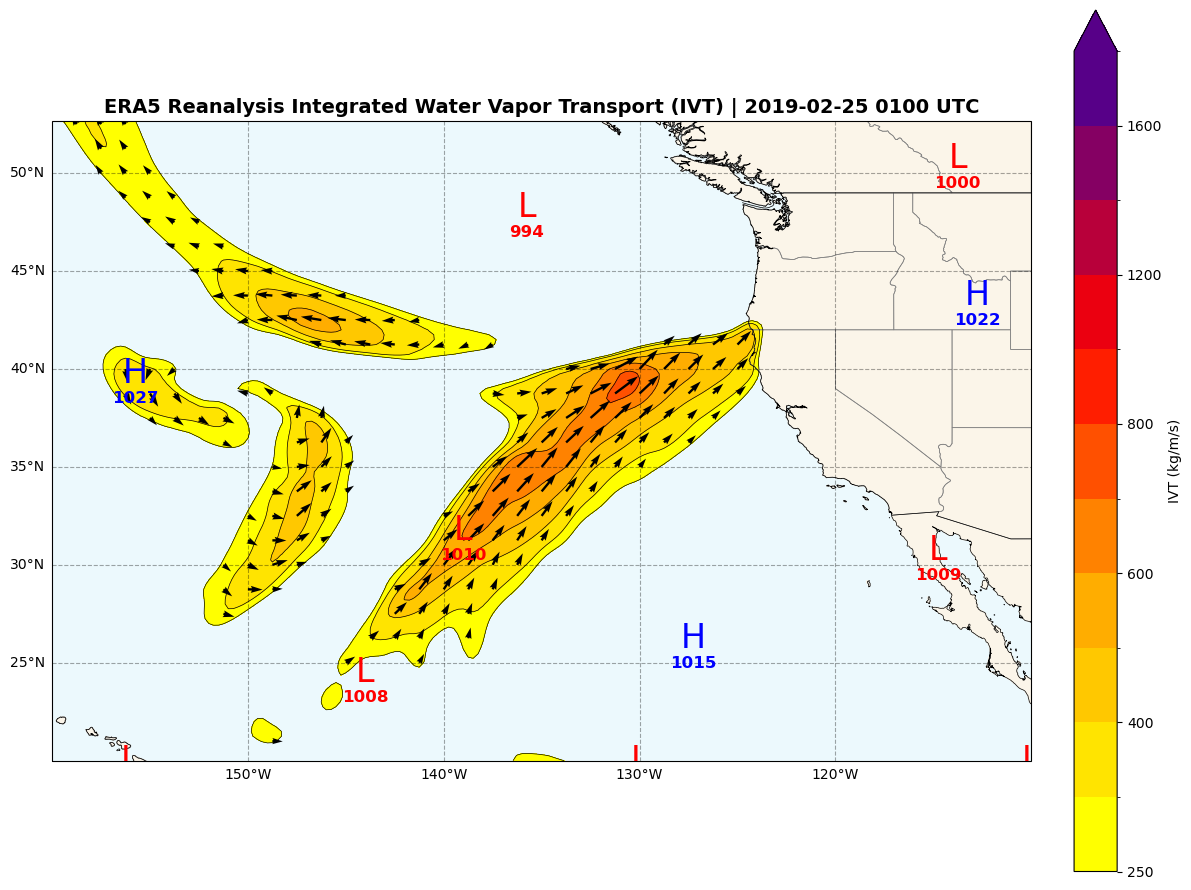

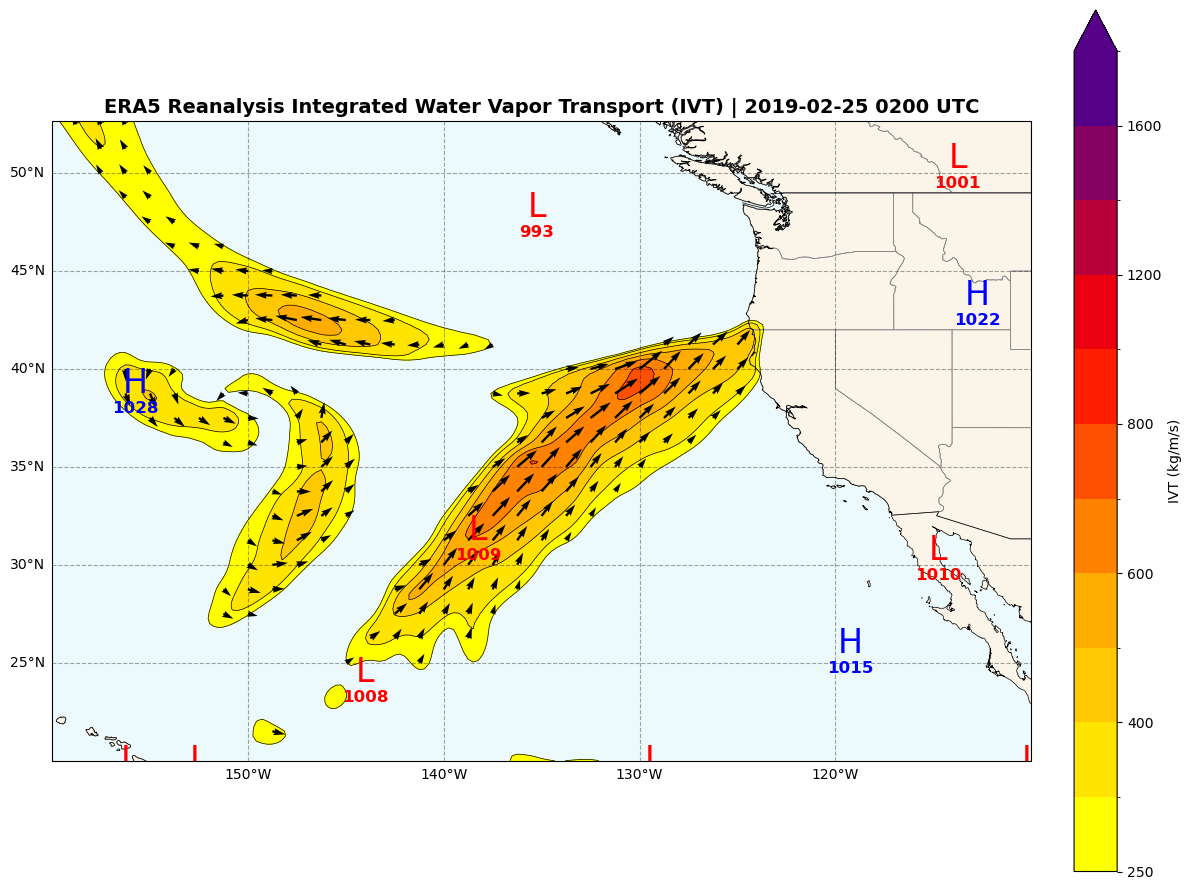

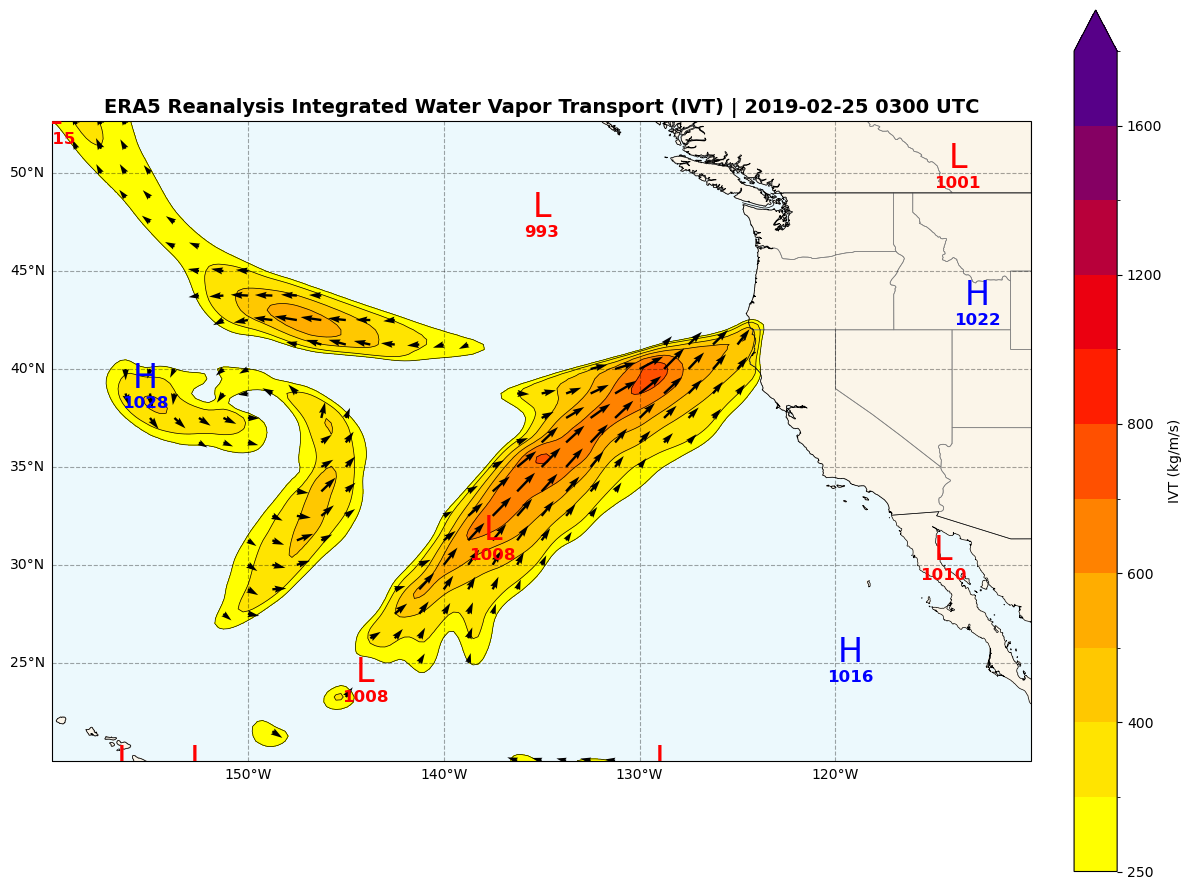

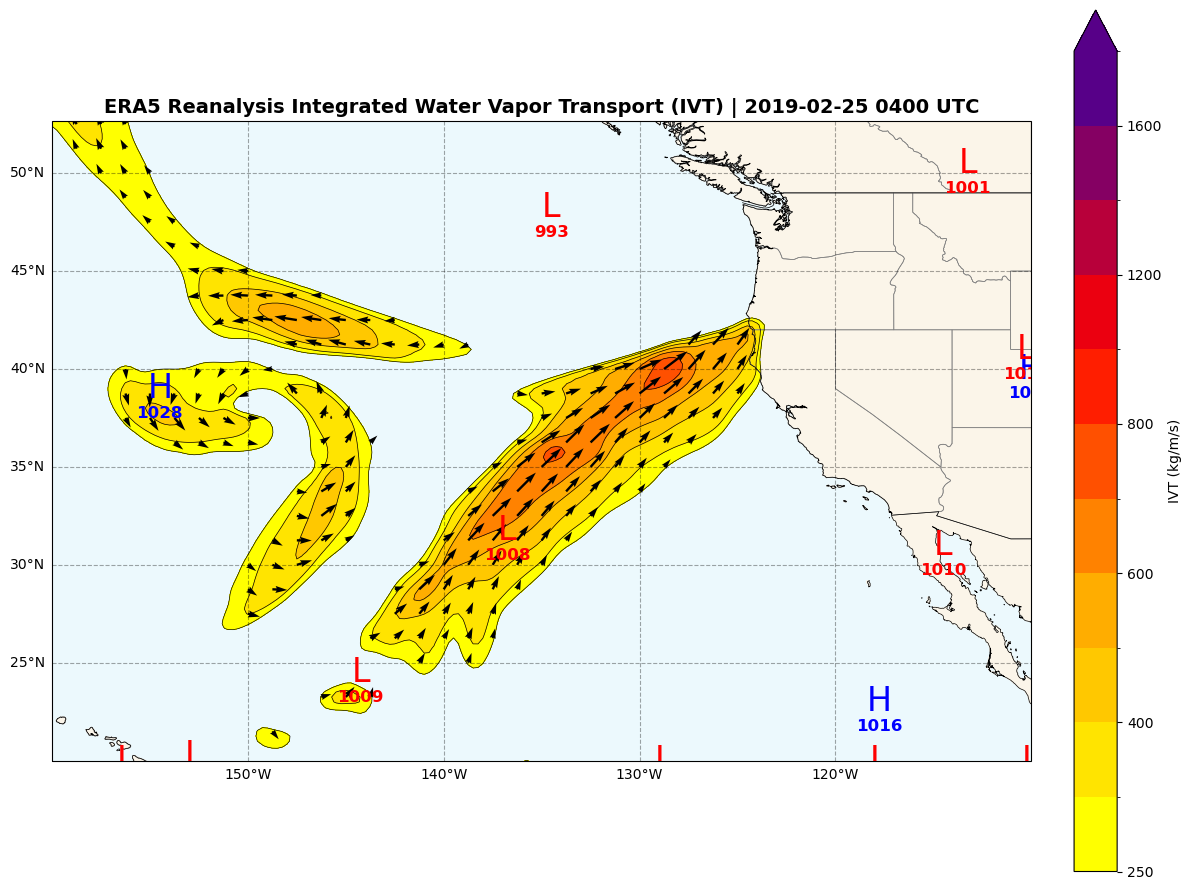

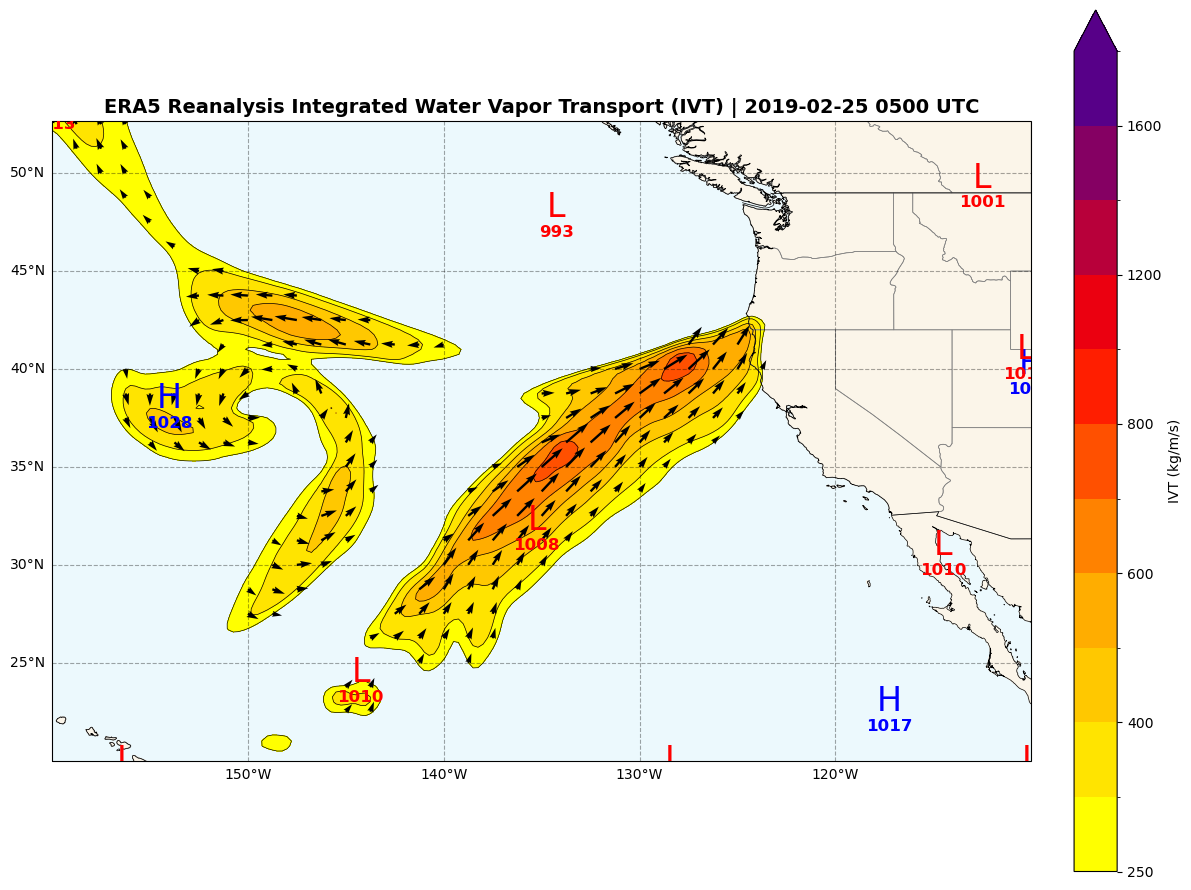

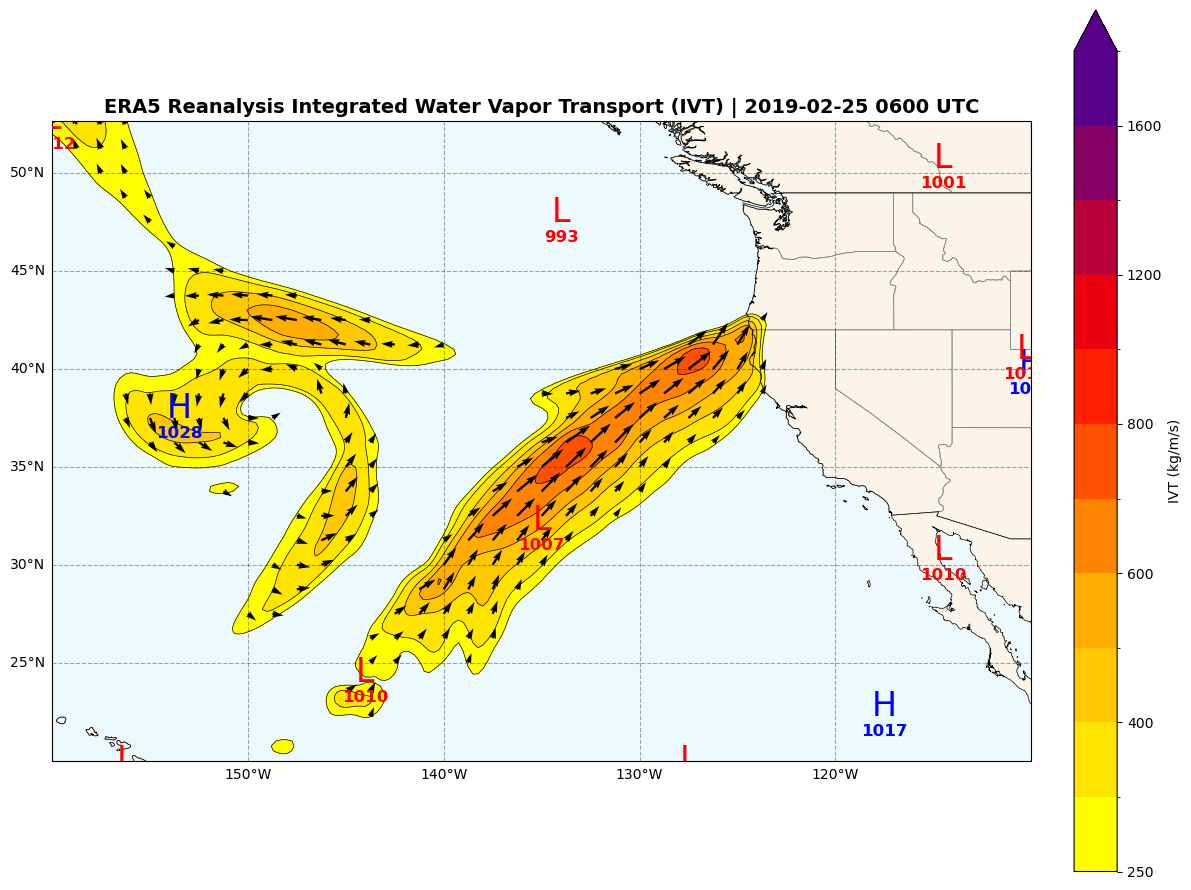

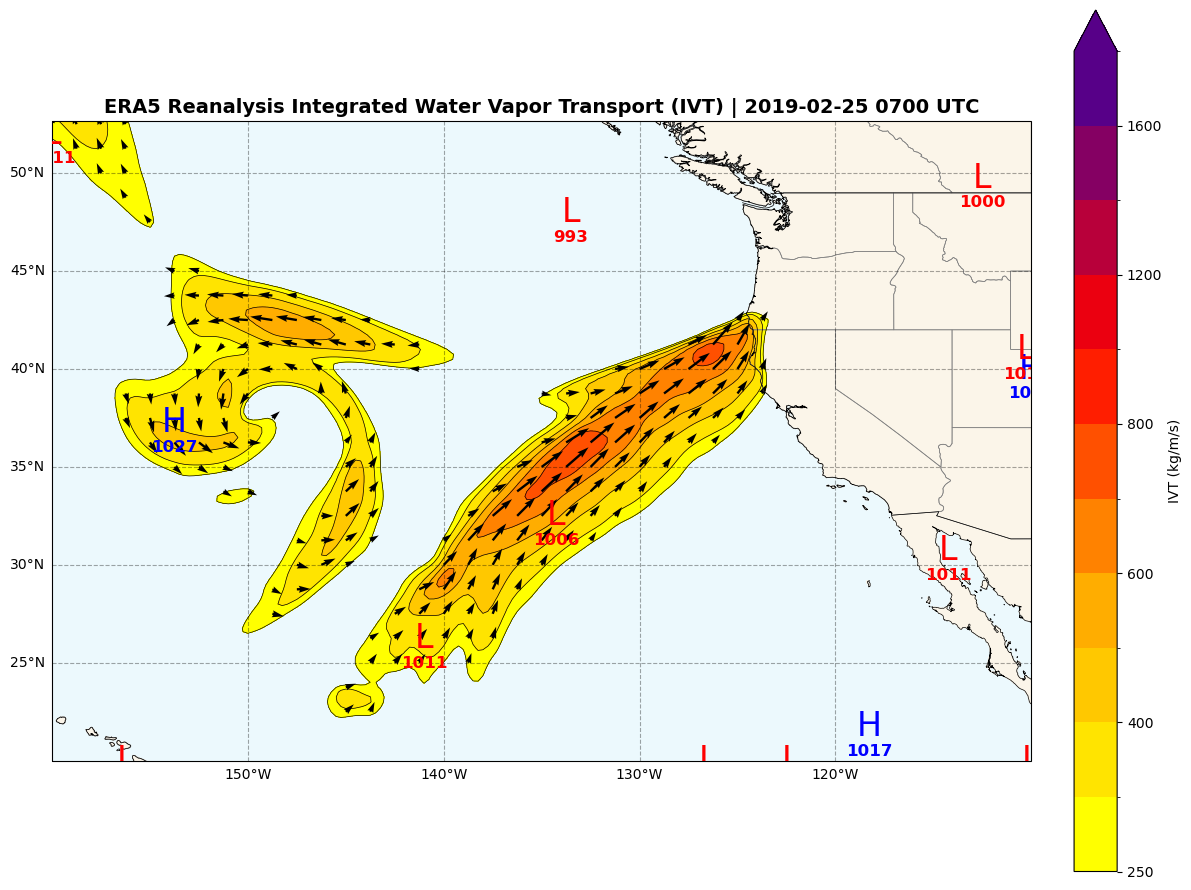

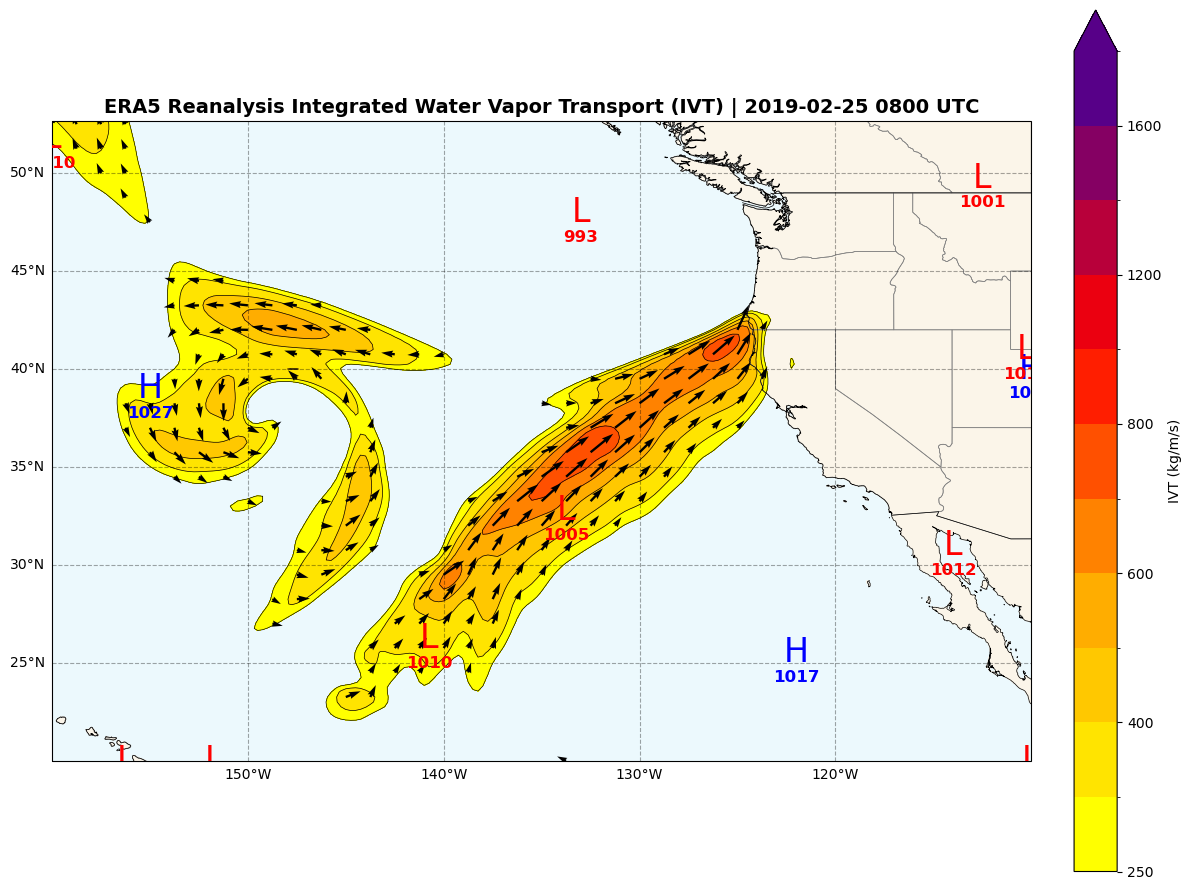

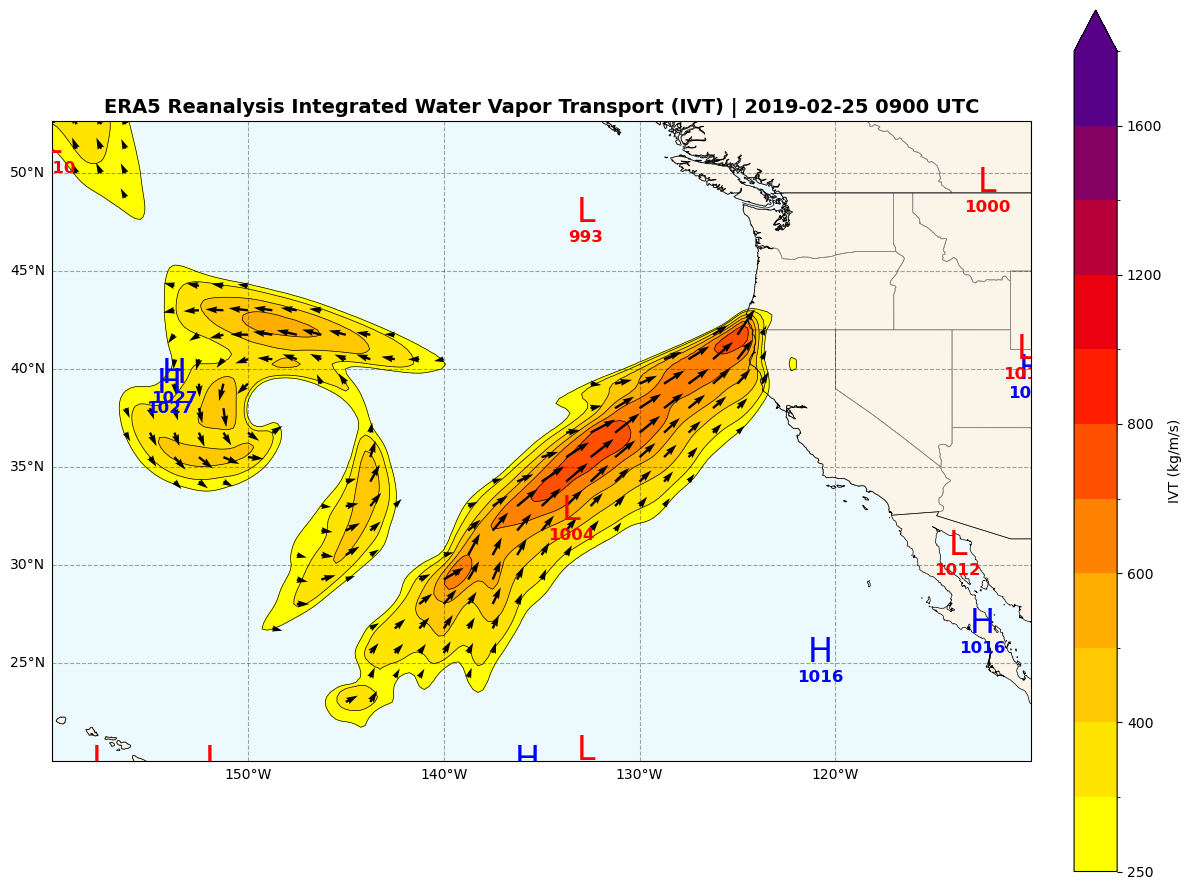

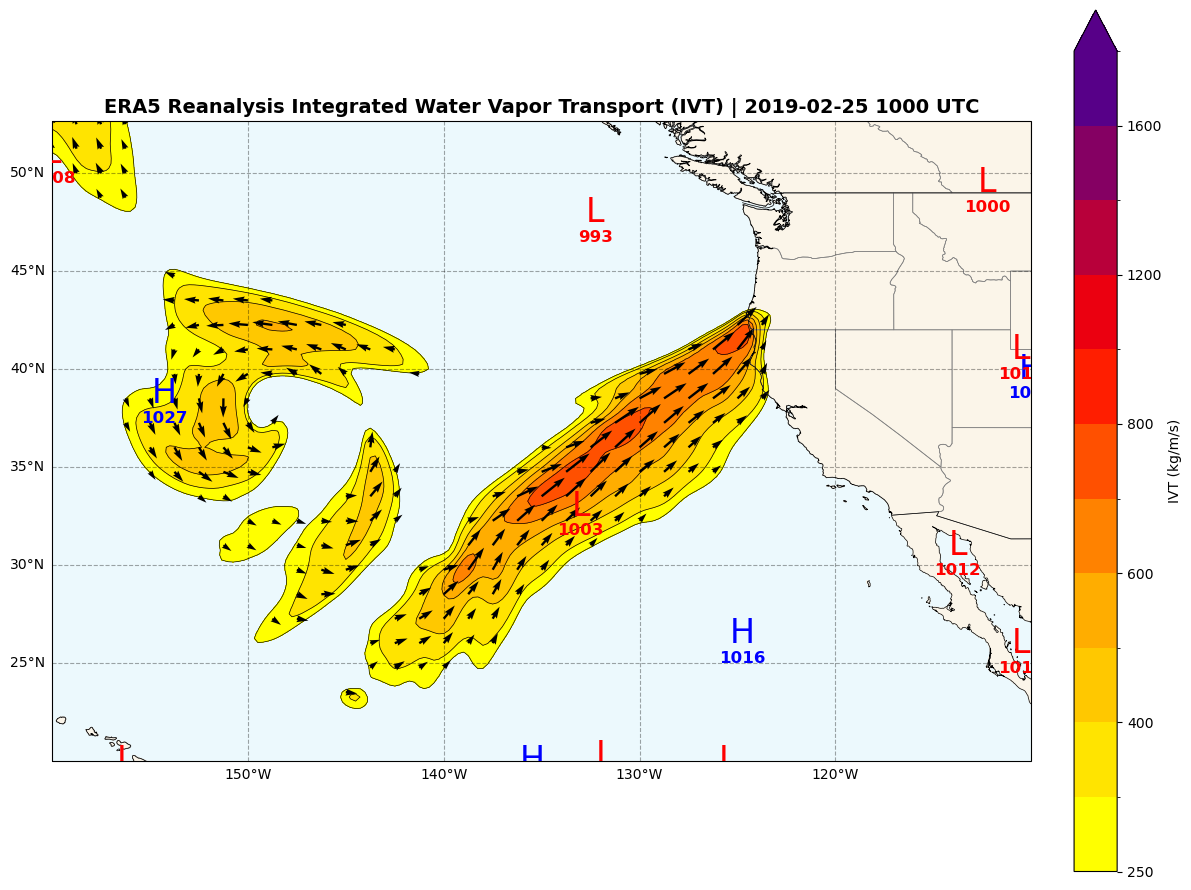

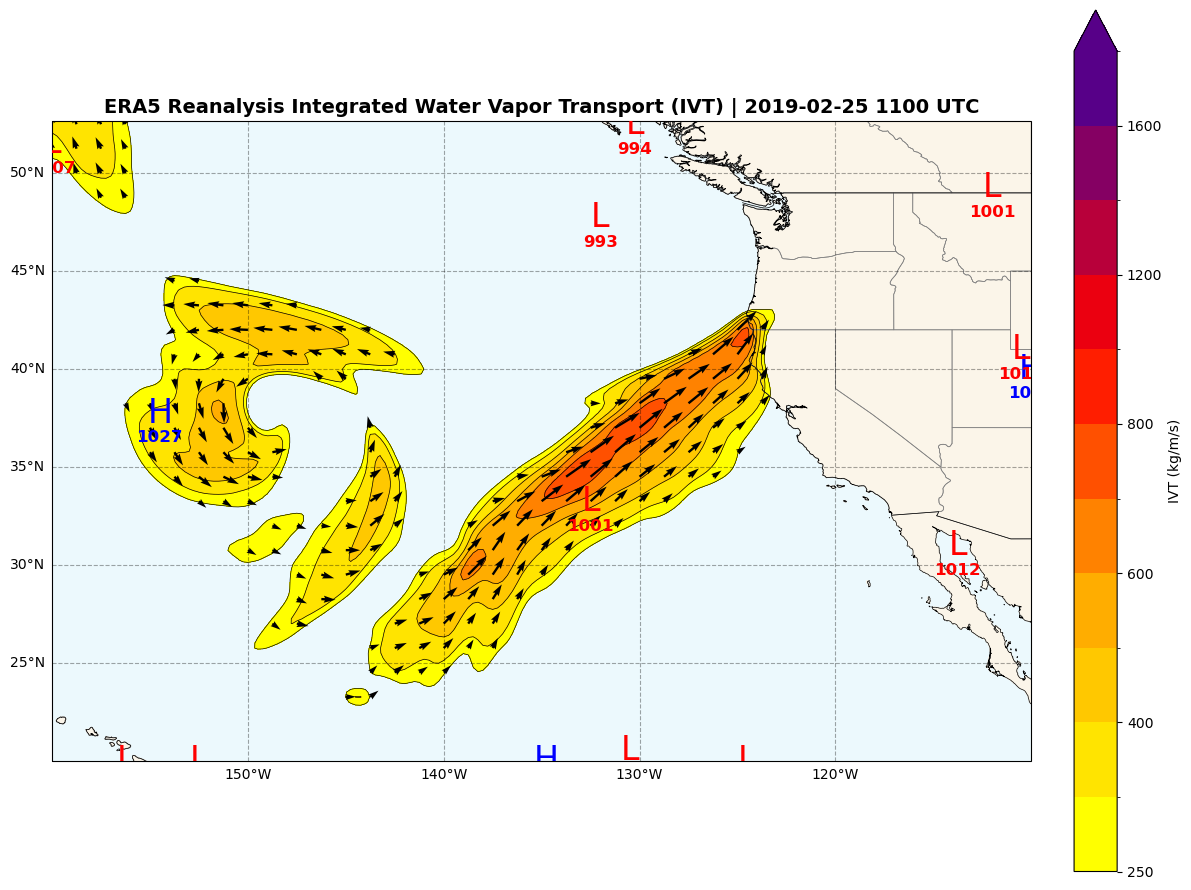

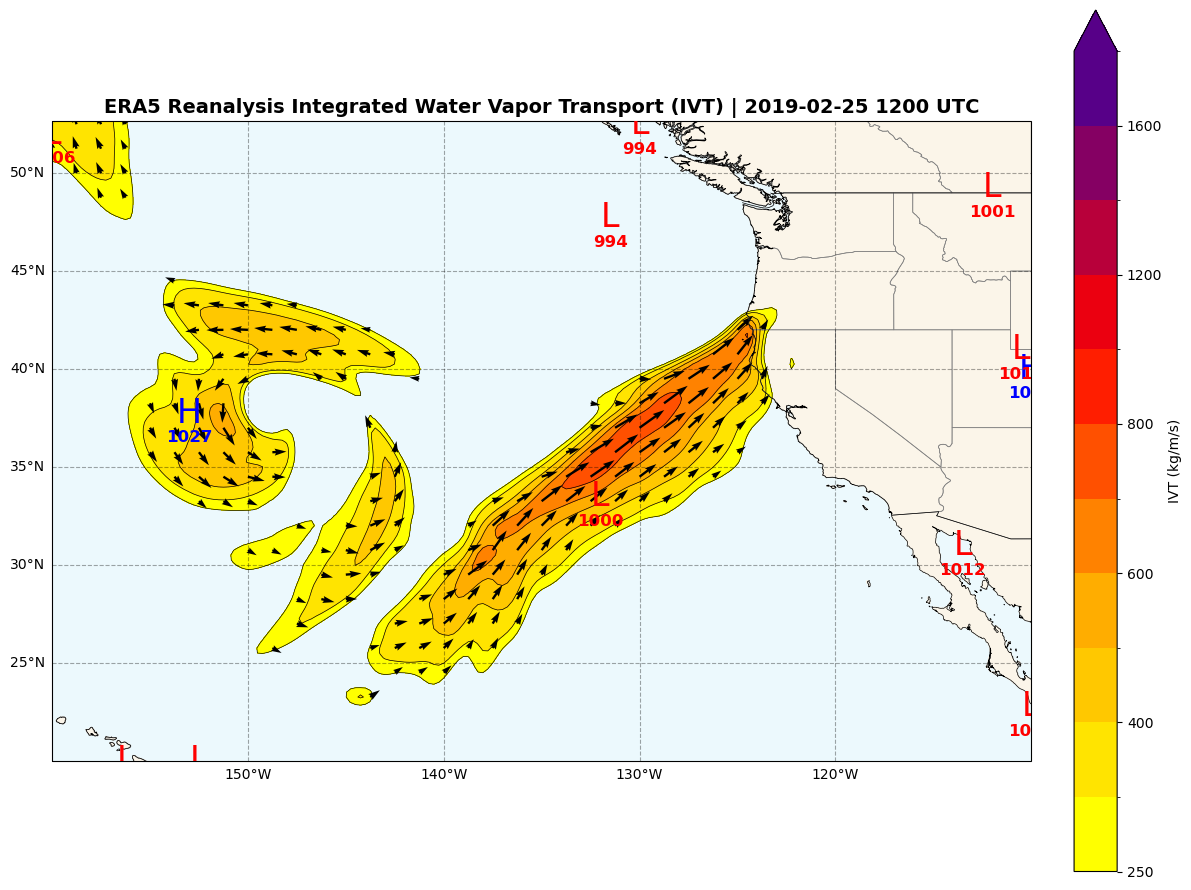

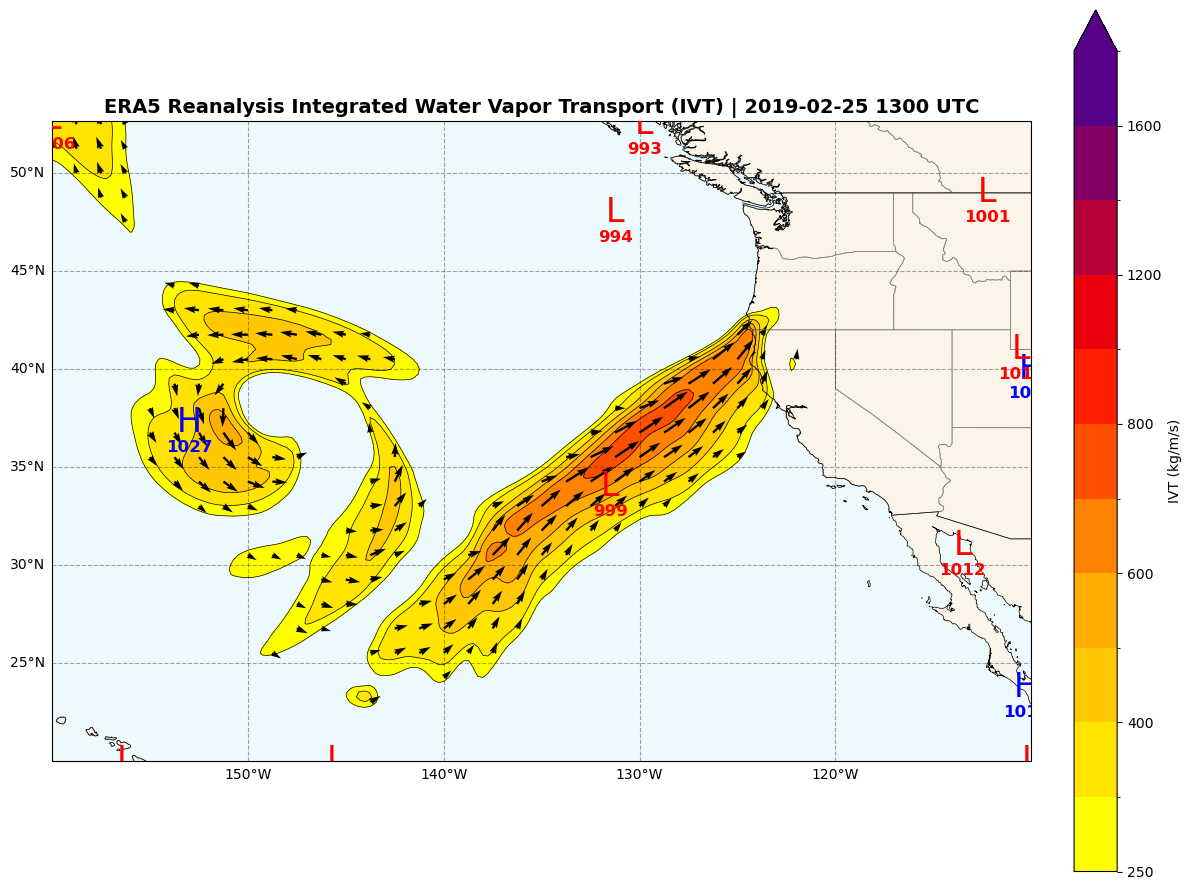

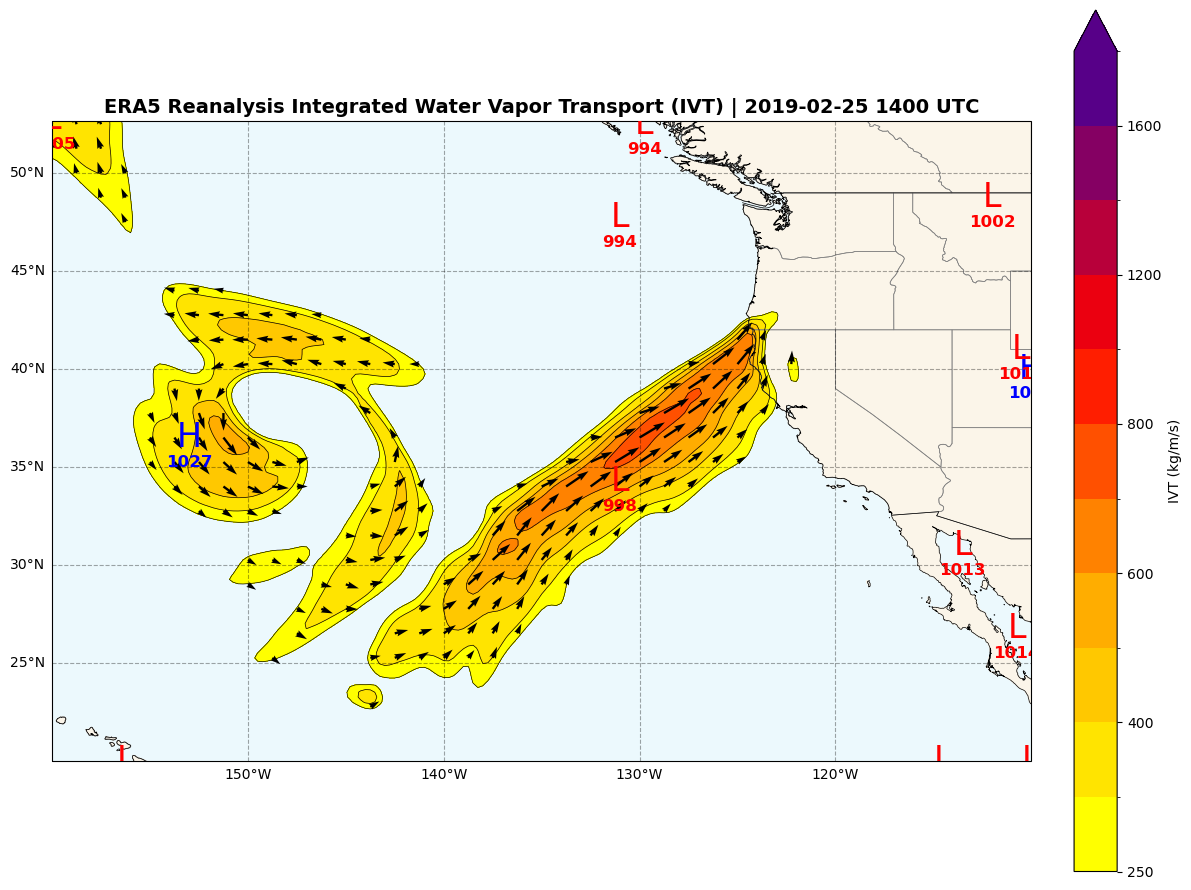

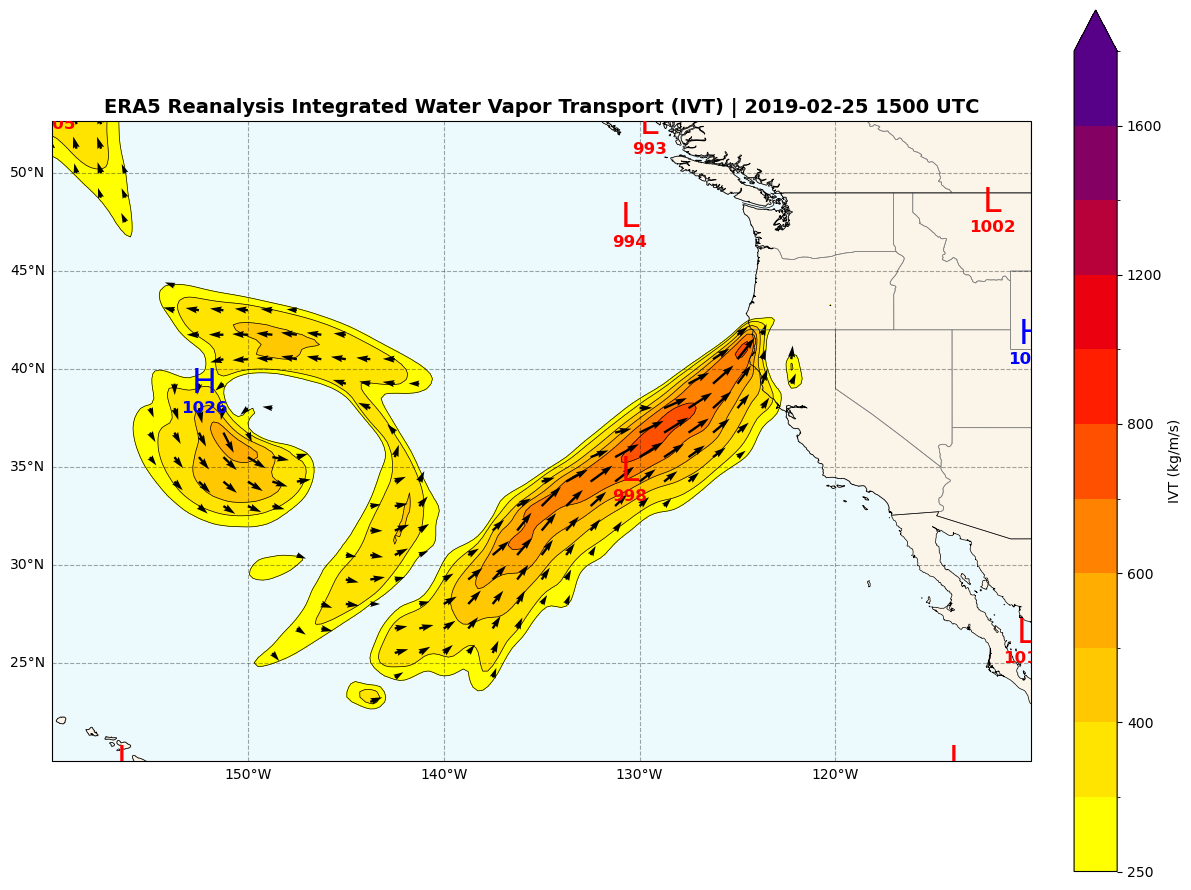

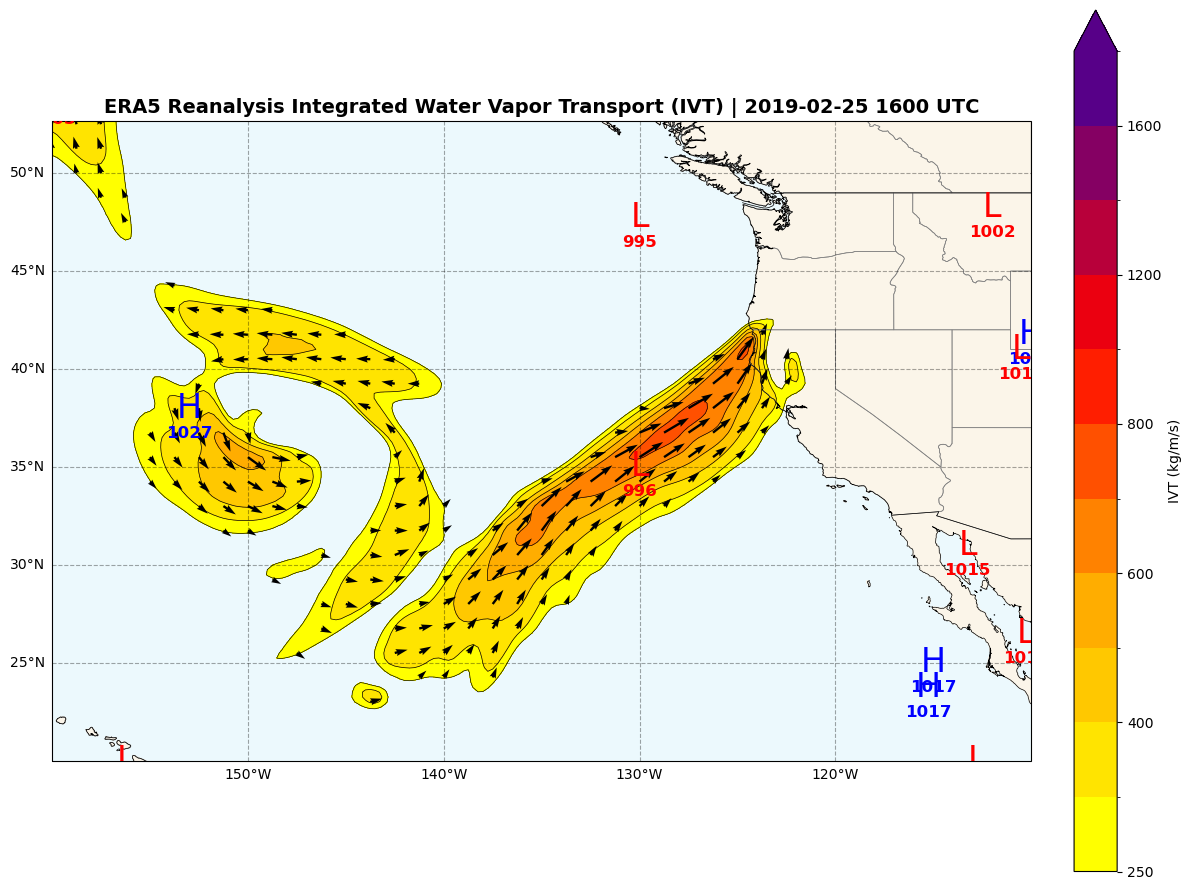

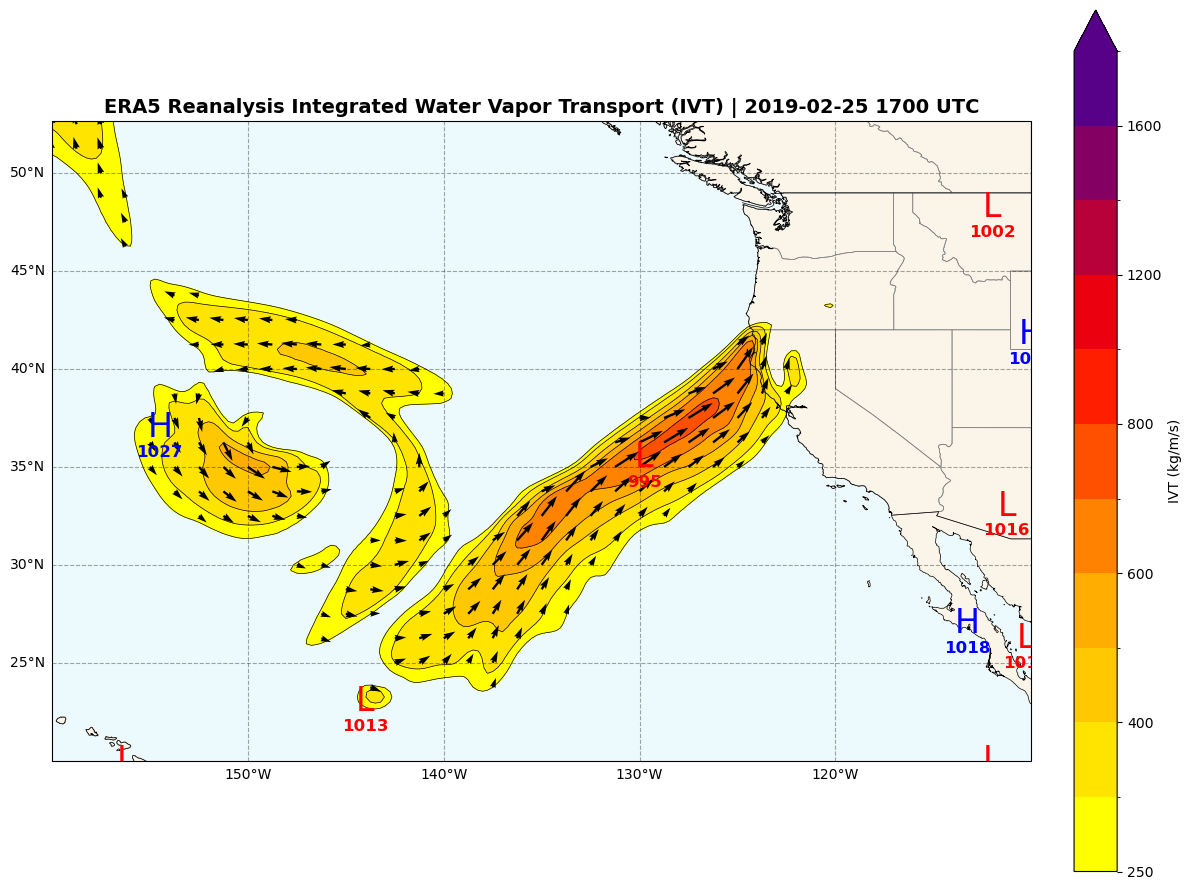

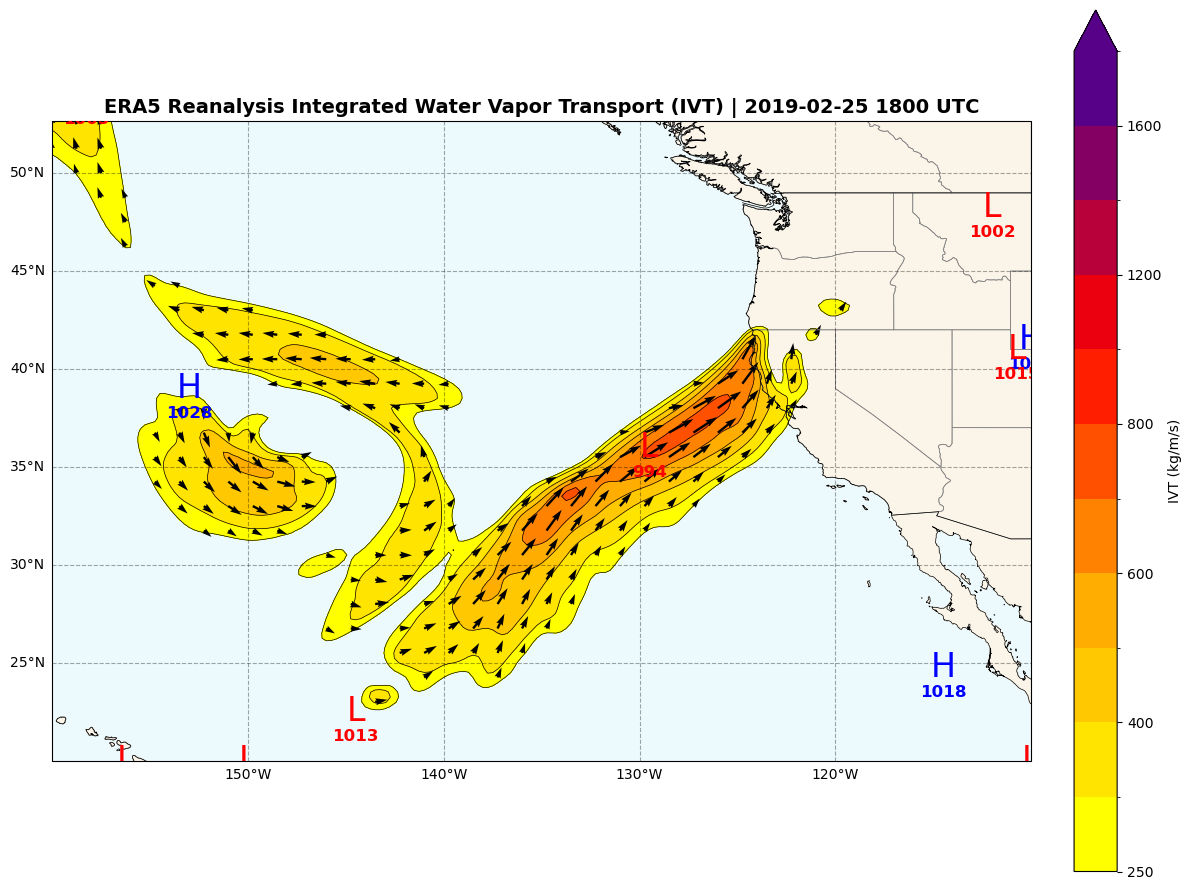

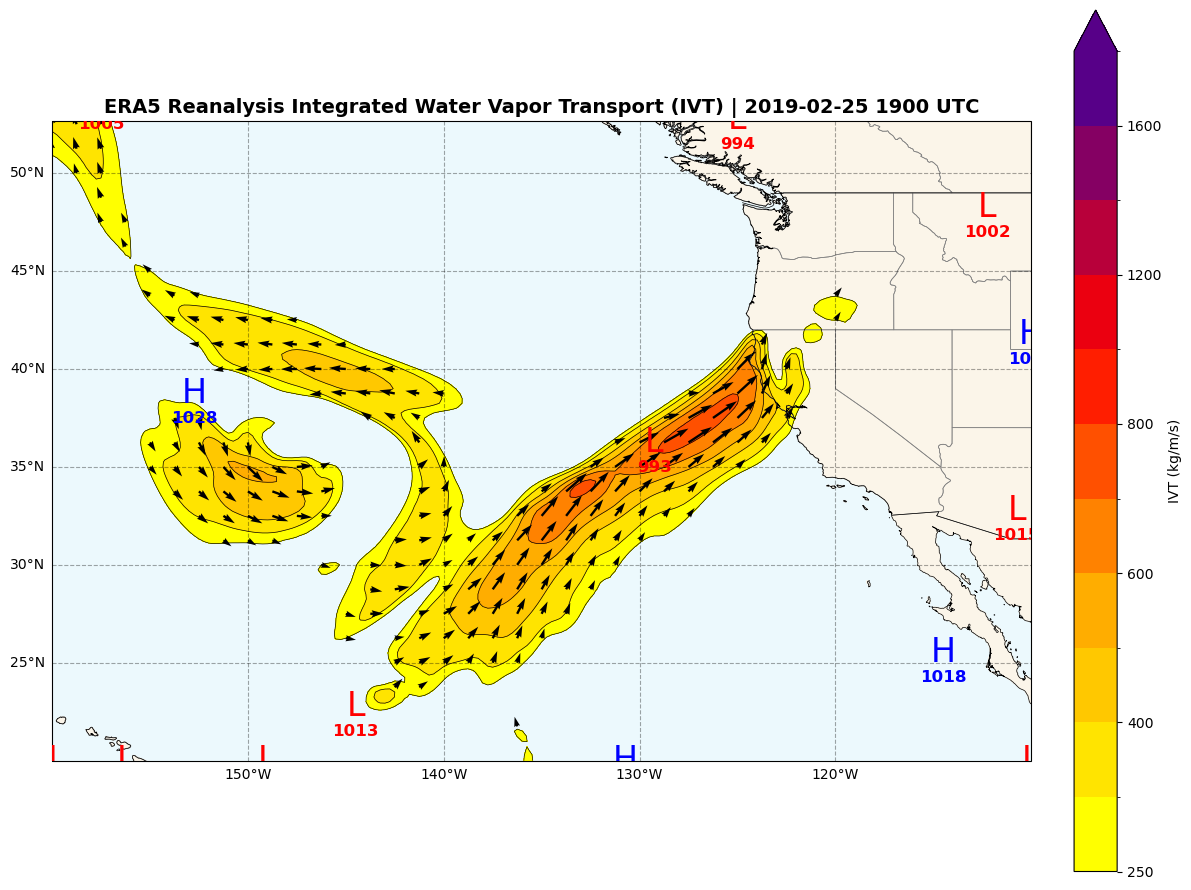

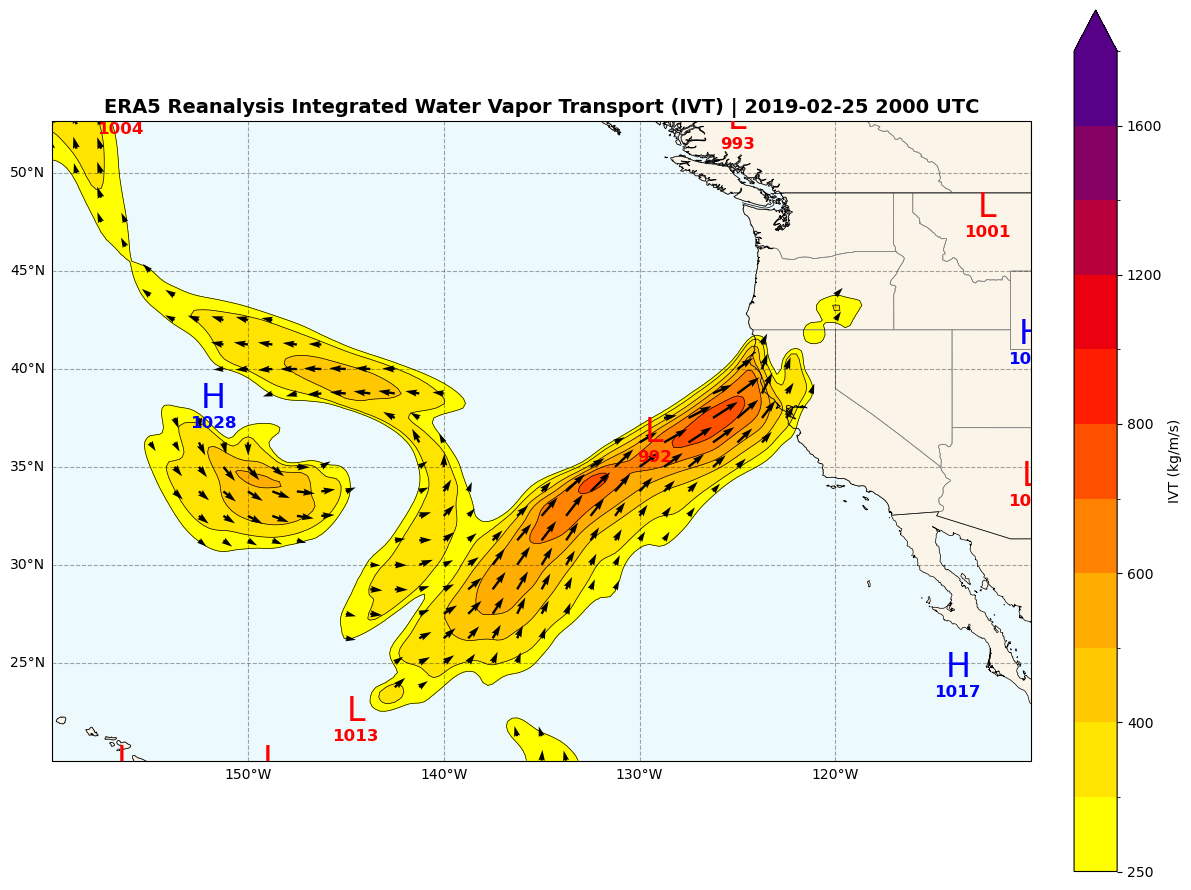

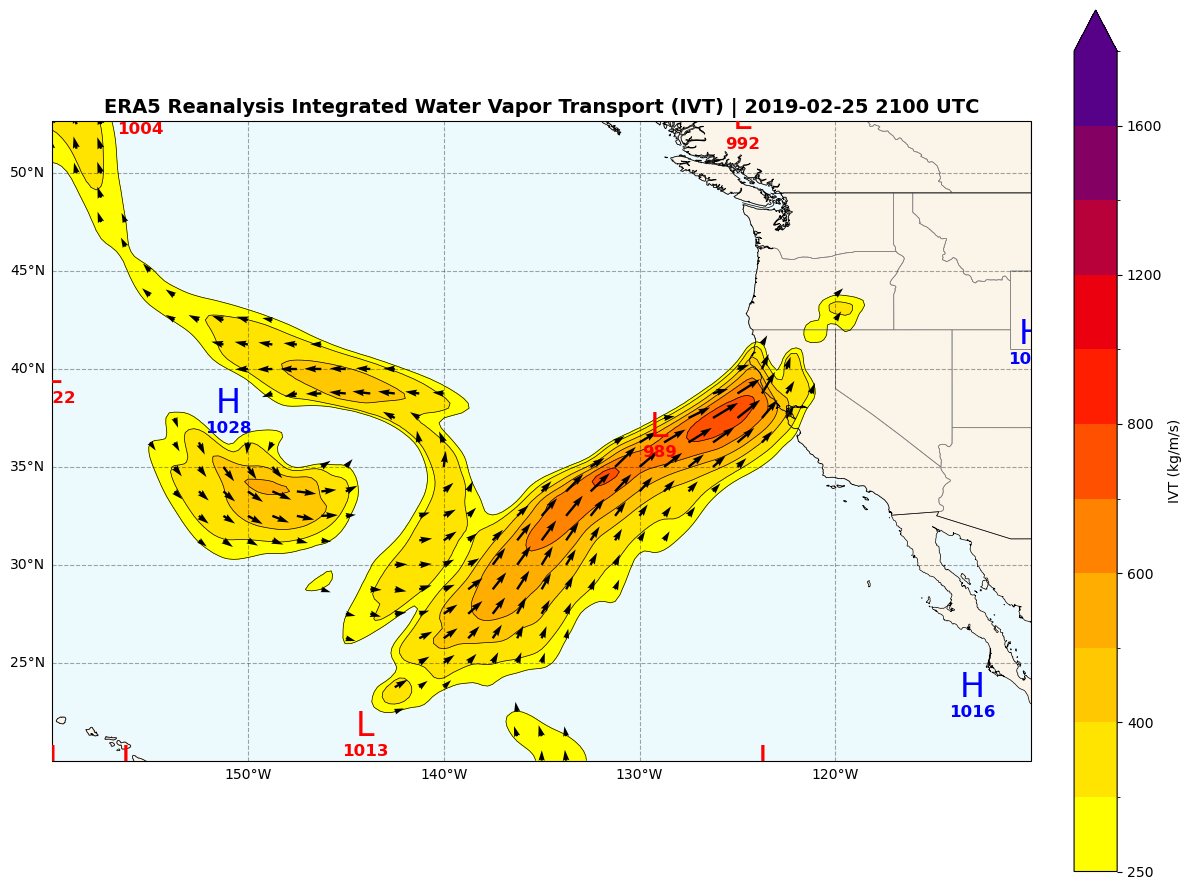

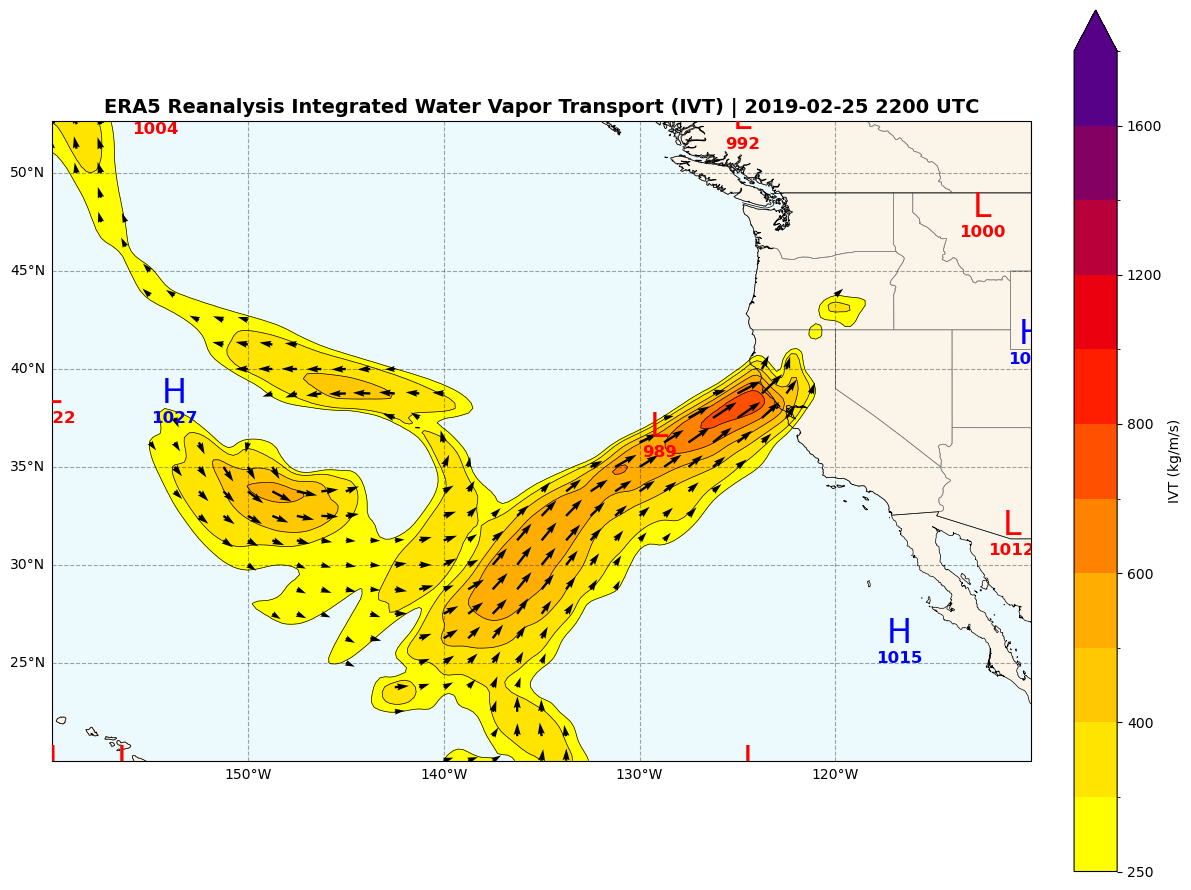

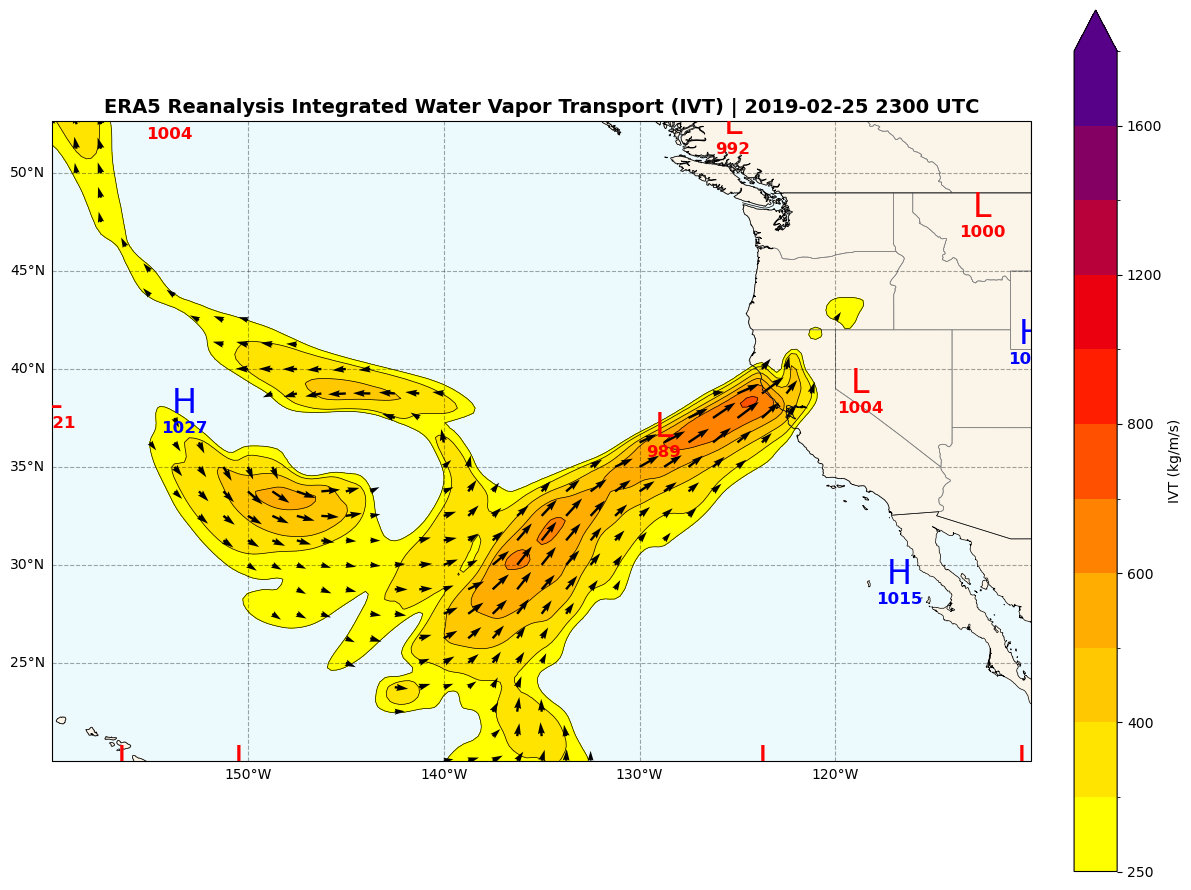

In [10]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None, ax=None, threshold=0.5):
    from scipy.ndimage import maximum_filter, minimum_filter
    import numpy as np

    if ax is None:
        ax = plt.gca()

    if extrema == 'max':
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif extrema == 'min':
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for extrema must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    # To keep track of unique points
    plotted_points = []

    for i in range(len(mxy)):
        lon_coord = lon[mxx[i]].item()
        lat_coord = lat[mxy[i]].item()
        
        # Check distance from already plotted points
        if not any(np.sqrt((lon_coord - lon_p)**2 + (lat_coord - lat_p)**2) < threshold for lon_p, lat_p in plotted_points):
            ax.text(lon_coord, lat_coord, symbol, color=color, size=24,
                    clip_on=True, clip_box=ax.bbox, horizontalalignment='center', 
                    verticalalignment='center', transform=transform)
            ax.text(lon_coord, lat_coord, 
                    '\n' + str(int(data[mxy[i], mxx[i]])), 
                    color=color, size=12, clip_on=True, clip_box=ax.bbox, 
                    fontweight='bold', horizontalalignment='center', 
                    verticalalignment='top', transform=transform)

            # Mark this point as plotted
            plotted_points.append((lon_coord, lat_coord))

def plot_250_isotachs_mslp(ds_pl, ds_sfc, directions):
    # Loop over the reanalysis time steps
    for i in range(0, len(ds_pl.time.values)):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        
        # Slice the dataset to get the data for the pressure level at 250 hPa
        u_250 = ds_pl_sliced['U'].sel(level=250) # units: m/s
        v_250 = ds_pl_sliced['V'].sel(level=250) # units: m/s
        z_250 = ds_pl_sliced['Z'].sel(level=250) / g # units: m
        pressure_levels = u_250.level * 100 # units: Pa

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

        # Calculate the wind speed at 250 hPa
        wind_speed_250 = np.sqrt(u_250**2 + v_250**2)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Get the lats and lons
        lats = mslp['latitude'][:]
        lons = mslp['longitude'][:] 
        
        # Smooth the mslp and wind speed
        mslp_smoothed = gaussian_filter(mslp, sigma=3)
        wnd_smoothed = gaussian_filter(wind_speed_250, sigma=3)

        # Define the color levels and colors for the isotachs
        levels = np.arange(20, 95, 5)
        colors = ['#daedfb', '#b7dcf6', '#91bae4', '#7099ce', '#6a999d', '#72ad63', '#77c14a', '#cad955', '#f8cf4f', '#f7953c', '#ef5f28', '#e13e26', '#cd1e28', '#b1181e', '#901617']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Create the plot 
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the geopotential heights and IWV
        c = plt.contour(mslp['longitude'], mslp['latitude'], mslp_smoothed, colors='black', levels=np.arange(960, 1080, 4), linewidths=0.5)
        ax.clabel(c, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        #c = plt.contour(u_250['longitude'], u_250['latitude'], wnd_smoothed, colors='black', levels=levels, linewidths=0.5)
        cf = plt.contourf(u_250['longitude'], u_250['latitude'], wnd_smoothed, cmap=cmap, norm=norm, levels=levels, extend='max')
        plt.colorbar(cf, orientation='vertical', label='Wind Speed (ms$^{-1}$)', fraction=0.046, pad=0.04)

        # Pass ax to plot_maxmin_points
        plot_maxmin_points(lons, lats, mslp_smoothed, 'max', 50, symbol='H', color='b', transform=ccrs.PlateCarree(), ax=ax)
        plot_maxmin_points(lons, lats, mslp_smoothed, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree(), ax=ax)

        #step = 5
        #ax.barbs(u_500['longitude'][::step], u_500['latitude'][::step], u_500[::step, ::step], v_500[::step, ::step], length=6, color='black')

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 250-hPa Isoatachs and MSLP | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North'] - 5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        plt.tight_layout()
        plt.show()

def plot_ivt_hl(g, ds_pl, ds_sfc, directions):
    # Loop over the reanlysis time steps
    for i in range(0, len(ds_pl.time)):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure levels between 500 and 1000 hPa
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 1000)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 1000)) # units: m/s
        q_sliced = ds_pl_sliced['Q'].sel(level=slice(500, 1000)) # units: kg/kg

        # Flip the order of the pressure levels and convert them to Pa from hPa
        pressure_levels = u_sliced.level[::-1] * 100 # units: Pa

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa
        
        # Get the lats and lons
        lats = mslp['latitude'][:]
        lons = mslp['longitude'][:] 

        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Create the figure
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the IVT
        c = plt.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=levels, linewidths=0.5)
        cf = plt.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(cf, orientation='vertical', label='IVT (kg/m/s)', fraction=0.046, pad=0.04)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')
        
        plot_maxmin_points(lons, lats, mslp, 'max', 50, symbol='H', color='b', transform=ccrs.PlateCarree(), ax=ax)
        plot_maxmin_points(lons, lats, mslp, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree(), ax=ax)

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis Integrated Water Vapor Transport (IVT) | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='#ecf9fd')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        plt.tight_layout()
        #plt.savefig(f'IVT_{i}.png', dpi=450)
        plt.show()


def plot_q_uv_zeta_hl(g, ds_pl, ds_sfc, directions):
    # Loop over the reanlysis time steps
    for i in range(0, len(ds_pl.time)):
        # Slice the dataset to get the data for the current time step
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)
        
        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))


        # Slice the dataset to get the data for the pressure levels at 850 hPa
        t_sliced = ds_pl_sliced['T'].sel(level=850) # units: K
        u_sliced = ds_pl_sliced['U'].sel(level=850) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=850) # units: m/s
        q_sliced = ds_pl_sliced['Q'].sel(level=850) * 1000 # units: g/kg

        # Calculate the potential temperature and relative vorticity
        theta_sliced = mpcalc.potential_temperature(850 * units.hPa, t_sliced) # units: K
        zeta_sliced = mpcalc.vorticity(u_sliced, v_sliced) # units: 10^-5 s^-1

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa
        
        # Get the lats and lons
        lats = mslp['latitude'][:]
        lons = mslp['longitude'][:] 

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        # Define the color levels and colors for the specific humidity
        levels = np.arange(4, 15, 1)
        colors = ['#c3e8fa', '#8bc5e9', '#5195cf', '#49a283', '#6cc04b', '#d8de5a', '#f8b348', '#f46328', '#dc352b', '#bb1b24', '#911618']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the specific humidity and potential temperature
        q_smoothed = gaussian_filter(q_sliced, sigma=1)
        theta_smoothed = gaussian_filter(theta_sliced, sigma=1)
        zeta_smoothed = gaussian_filter(zeta_sliced, sigma=1)

        # Create the figure
        fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

        # Plot the specific humidity, potential temperature, and wind barbs
        plt.contour(zeta_sliced['longitude'], zeta_sliced['latitude'], zeta_smoothed, colors='purple', levels=np.arange(10 * 10**-5, 30 * 10**-5, 10**-5), linewidths=0.5)
        plt.contour(theta_sliced['longitude'], theta_sliced['latitude'], theta_smoothed, colors='black', levels=np.arange(220, 340, 1), linewidths=0.5)
        cf = plt.contourf(q_sliced['longitude'], q_sliced['latitude'], q_smoothed, cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(cf, orientation='vertical', label='Specific Humidity (g kg$^{-1}$)', fraction=0.046, pad=0.04)

        
        # Plot the 850-hPa wind barbs
        step = 10 
        ax.barbs(u_sliced['longitude'][::step], u_sliced['latitude'][::step], u_sliced[::step, ::step], v_sliced[::step, ::step], length=6, color='black')
        
        plot_maxmin_points(lons, lats, mslp, 'max', 50, symbol='H', color='b', transform=ccrs.PlateCarree(), ax=ax)
        plot_maxmin_points(lons, lats, mslp, 'min', 25, symbol='L', color='r', transform=ccrs.PlateCarree(), ax=ax)

        # Add the title, set the map extent, and add map features
        plt.title(f'ERA5 Reanalysis 850-hPa Specific Humidity, $\\theta$, $\\zeta, $and Wind Barbs | {int_datetime_index[0].strftime("%Y-%m-%d %H00 UTC")}', fontsize=14, weight='bold')
        ax.set_extent([directions['West'], directions['East'], directions['South'], directions['North']-5])
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='white')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, color='#fbf5e9')
        gls = ax.gridlines(draw_labels=True, color='black', linestyle='--', alpha=0.35)
        gls.top_labels = False
        gls.right_labels = False
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        plt.tight_layout()
        #plt.savefig(f'IVT_{i}.png', dpi=450)
        plt.show()

if __name__ == '__main__':
    directions = {'North': 55, 
                  'East': 250, 
                  'South': 20, 
                  'West': 200}
    g = 9.81 # units: m/s^2
    #plot_250_isotachs_mslp(ds_pl, ds_sfc, directions)
    plot_ivt_hl(g, ds_pl, ds_sfc, directions)
    #plot_q_uv_zeta_hl(g, ds_pl, ds_sfc, directions)